In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns

import itertools
import pickle

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, Bidirectional

from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, confusion_matrix

In [2]:
DATASET_PATH = '../../data/ftb1u-v1/sentences'

### Load train data

In [3]:
with open(f'{DATASET_PATH}/case_train_pos.pkl', 'rb') as f:
    train = pickle.load(f)

In [4]:
train[:5]

[[('Tammikuussa|NOUN', 'Ine'),
  ('hän|PRON', 'Nom'),
  ('muutti|VERB', 'Unk'),
  ('Ilkan|PROPN', 'Gen'),
  ('luokse|ADP', 'Unk'),
  ('Saviselkään|PROPN', 'Ill'),
  (',|PUNCT', 'Unk'),
  ('kevättalvi|NOUN', 'Nom'),
  ('koeteltiin|VERB', 'Unk'),
  ('toinen|PRON', 'Nom'),
  ('toisensa|DET', 'Gen'),
  ('luonnetta|NOUN', 'Par'),
  ('ja|CONJ', 'Unk'),
  ('kesällä|NOUN', 'Ade'),
  ('mentiin|VERB', 'Unk'),
  ('naimisiin|ADV', 'Unk'),
  ('.|PUNCT', 'Unk')],
 [('rakkaat|ADJ', 'Nom'),
  ('isä|NOUN', 'Nom'),
  ('ja|CONJ', 'Unk'),
  ('äiti|NOUN', 'Nom'),
  ('.|PUNCT', 'Unk')],
 [('Pitipä|VERB', 'Unk'), ('sattua|VERB', 'Lat'), ('.|PUNCT', 'Unk')],
 [('Nyt|ADV', 'Unk'), ('säästäminen|NOUN', 'Nom'), ('kannattaa|VERB', 'Unk')],
 [('Monet|PRON', 'Nom'),
  ('eivät|VERB', 'Unk'),
  ('vielä|ADV', 'Unk'),
  ('ole|VERB', 'Unk'),
  ('epäonnekseen|NOUN', 'Tra'),
  ('saaneet|VERB', 'Nom'),
  ('työpaikkaa|NOUN', 'Par'),
  ('.|PUNCT', 'Unk')]]

In [5]:
MAX_LENGTH = len(max(train, key=len))
MAX_LENGTH

72

In [6]:
%%time
train_sentences, train_sentence_tags = [], [] 
for tagged_sentence in train:
    sentence, tags = zip(*tagged_sentence)
    train_sentences.append(np.array(sentence))
    train_sentence_tags.append(np.array(tags))

CPU times: user 86.8 ms, sys: 567 µs, total: 87.4 ms
Wall time: 83.4 ms


### Encode data

In [7]:
words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        w = w.lower()
        word, pos = w.rsplit('|', 1)
        ending = word[-4:] if len(word) >= 4 else word
        words.add(ending + f'|{pos}')
        words.add(f'-OOV-|{pos}')

for ts in train_sentence_tags:
    for t in ts:
        tags.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-OOV-'] = 1
word2index['-PAD-'] = 0
 
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0

In [8]:
def encode_sentences(sentences, sentence_tags):
    sentences_X, tags_y = [], []

    for s in sentences:
        s_int = []
        for t in s:
            t = t.lower()
            w, p = t.rsplit('|', 1)
            ending = w[-4:] if len(w) >= 4 else w
            end = f'{ending}|{p}'
            if end not in word2index:
                end = f'-OOV-|{p}'
            s_int.append(word2index.get(end, word2index['-OOV-']))

        sentences_X.append(s_int)

    for s in sentence_tags:
        tags_y.append([tag2index[t] for t in s])
    return sentences_X, tags_y

In [9]:
%%time
train_sentences_X, train_tags_y = encode_sentences(train_sentences, train_sentence_tags)

CPU times: user 233 ms, sys: 0 ns, total: 233 ms
Wall time: 232 ms


### Load test data

In [10]:
with open(f'{DATASET_PATH}/case_test_pos.pkl', 'rb') as f:
    test = pickle.load(f)

In [11]:
test[:5]

[[('Bajul|PROPN', 'Nom'),
  ('ei|VERB', 'Unk'),
  ('kauan|ADV', 'Unk'),
  ('viihdy|VERB', 'Unk'),
  ('ammattilaisena|NOUN', 'Ess'),
  ('.|PUNCT', 'Unk')],
 [('mennä|VERB', 'Lat'), ('päivälliselle|NOUN', 'All')],
 [('Pihassamme|NOUN', 'Ine'),
  ('kasvaa|VERB', 'Unk'),
  ('koivun|NOUN', 'Gen'),
  ('juurella|ADP', 'Unk'),
  ('sitkeä|ADJ', 'Nom'),
  (',|PUNCT', 'Unk'),
  ('ikivihreä|ADJ', 'Nom'),
  ('kasvi|NOUN', 'Nom'),
  ('.|PUNCT', 'Unk')],
 [('En|VERB', 'Unk'),
  ('oo|VERB', 'Unk'),
  ('itte|PRON', 'Nom'),
  ('ainakaan|ADV', 'Unk'),
  ('vielä|ADV', 'Unk'),
  ('harrastanut|VERB', 'Nom'),
  ('tota|DET', 'Par'),
  ('yöllä|NOUN', 'Ade'),
  ('syömistä|NOUN', 'Par'),
  ('.|PUNCT', 'Unk')],
 [('Työttömyyteen|NOUN', 'Ill'),
  ('on|VERB', 'Unk'),
  ('käytävä|VERB', 'Nom'),
  ('käsiksi|ADV', 'Unk'),
  ('kaikella|DET', 'Ade'),
  ('sillä|DET', 'Ade'),
  ('tarmolla|NOUN', 'Ade'),
  (',|PUNCT', 'Unk'),
  ('joka|PRON', 'Nom'),
  ('meistä|DET', 'Ela'),
  ('suomalaisista|ADJ', 'Ela'),
  ('löytyy|VERB',

In [12]:
%%time
test_sentences, test_sentence_tags = [], [] 
for tagged_sentence in test:
    sentence, tags = zip(*tagged_sentence)
    test_sentences.append(np.array(sentence))
    test_sentence_tags.append(np.array(tags))

CPU times: user 34.6 ms, sys: 3.72 ms, total: 38.3 ms
Wall time: 35.3 ms


In [13]:
%%time
test_sentences_X, test_tags_y = encode_sentences(test_sentences, test_sentence_tags)

CPU times: user 62.1 ms, sys: 0 ns, total: 62.1 ms
Wall time: 61.7 ms


#### Padding

In [14]:
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [15]:
train_sentences_X.shape, train_tags_y.shape

((15277, 72), (15277, 72))

In [16]:
test_sentences_X.shape, test_tags_y.shape

((3820, 72), (3820, 72))

### Define model and evaluation functions

In [17]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
batch_size = 64

vocab_size = len(word2index)
classes = len(tag2index)

dropout = 0.2
lstm_recurrent_dropout = 0.2

In [19]:
# Word Input
word_feats_in = Input(shape=(MAX_LENGTH,), name='word_ending_input')

# Word Embedding Using Thai2Fit
word_feats_embeddings = Embedding(input_dim=vocab_size,
                            output_dim=50,
                            input_length=MAX_LENGTH,
                            mask_zero=False,
                            name='word_ending_embedding')(word_feats_in)
word_feats_enc = Bidirectional(LSTM(units=50, return_sequences=True, 
                dropout=dropout, recurrent_dropout=lstm_recurrent_dropout,
                name='word_ending_encoder'))(word_feats_embeddings)

# CRF
out = Dense(classes, activation='softmax', name='case_decoder')(word_feats_enc)

# Model
model = Model(word_feats_in, out)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision_m, recall_m, f1_m])

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_ending_input (InputLaye (None, 72)                0         
_________________________________________________________________
word_ending_embedding (Embed (None, 72, 50)            474600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 72, 100)           40400     
_________________________________________________________________
case_decoder (Dense)         (None, 72, 18)            1818      
Total params: 516,818
Trainable params: 516,818
Non-trainable params: 0
_________________________________________________________________


### Fit model

In [ ]:
history = model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)),
                    epochs=10, verbose=1,
                    validation_data=(test_sentences_X, to_categorical(test_tags_y, len(tag2index))))

### Evaluate train model

In [23]:
scores, acc, p, r, f = model.evaluate(train_sentences_X, to_categorical(train_tags_y, len(tag2index)))
scores, acc, p, r, f

15277/15277 [==============================] - 3s 200us/step


(0.004518307117757351,
 0.9986390471458435,
 0.9989011883735657,
 0.9984021186828613,
 0.9986503720283508)

#### Plot scores

In [24]:
from matplotlib import pyplot as plt

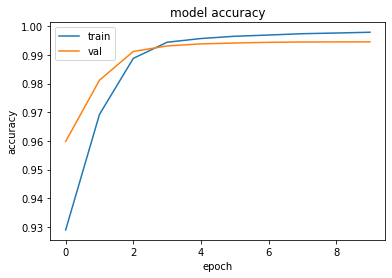

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

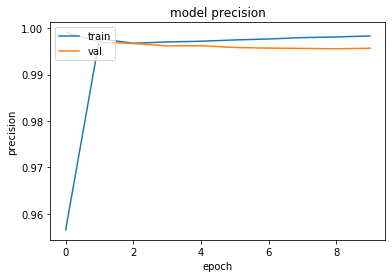

In [26]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

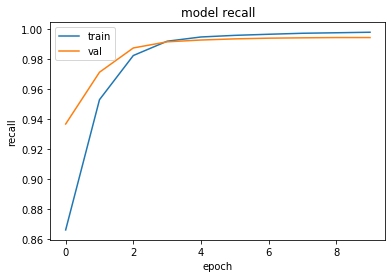

In [27]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

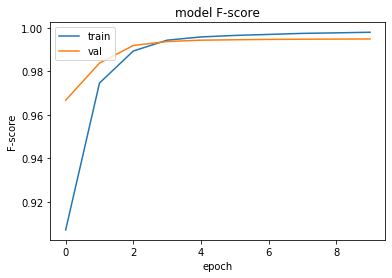

In [28]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model F-score')
plt.ylabel('F-score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

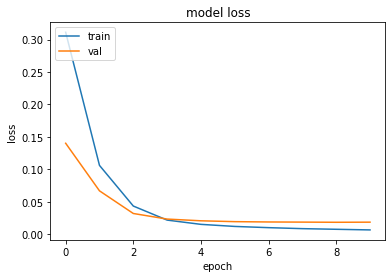

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate test dataset

In [30]:
scores, acc, p, r, f = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
scores, acc, p, r, f

3820/3820 [==============================] - 1s 201us/step


(0.018404287302681288,
 0.9945716857910156,
 0.9956685304641724,
 0.9940922856330872,
 0.9948796629905701)

### Make predictions

In [31]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequences.append([index[cat] for cat in np.argmax(categorical_sequence, axis=1)])
 
    return token_sequences

In [32]:
inverted_tag_index = {i: t for t, i in tag2index.items()}

In [33]:
%%time
predictions = model.predict(test_sentences_X)

CPU times: user 3.46 s, sys: 279 ms, total: 3.74 s
Wall time: 865 ms


In [34]:
%%time
pred_labels = logits_to_tokens(predictions, inverted_tag_index)

CPU times: user 74.3 ms, sys: 0 ns, total: 74.3 ms
Wall time: 73.9 ms


In [35]:
pred_labels[:5]

[['Nom',
  'Unk',
  'Unk',
  'Unk',
  'Ess',
  'Unk',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-'],
 ['Lat',
  'All',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '

### Classification report

In [36]:
y_true = [inverted_tag_index[t] for l in test_tags_y for t in l]
y_pred = list(itertools.chain(*pred_labels))

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       -PAD-       1.00      1.00      1.00    242650
         Abe       1.00      0.79      0.88        42
         Abl       0.94      0.83      0.88       189
         Acc       1.00      1.00      1.00        25
         Ade       0.98      0.96      0.97       649
         All       0.97      0.96      0.96       359
         Com       0.70      0.78      0.74        18
         Ela       0.82      0.88      0.85       703
         Ess       0.97      0.90      0.94       333
         Gen       0.93      0.92      0.93      2795
         Ill       0.89      0.86      0.88       817
         Ine       0.97      0.97      0.97       842
         Ins       0.78      0.69      0.73        67
         Lat       0.92      0.92      0.92       649
         Nom       0.91      0.96      0.93      6089
         Par       0.93      0.90      0.92      2428
         Tra       0.98      0.94      0.96       214
         Unk       0.99    

### Build confusion matrices

In [38]:
labels = list(sorted(set(y_true)))
array = confusion_matrix(y_true=y_true, y_pred=y_pred)

Precision

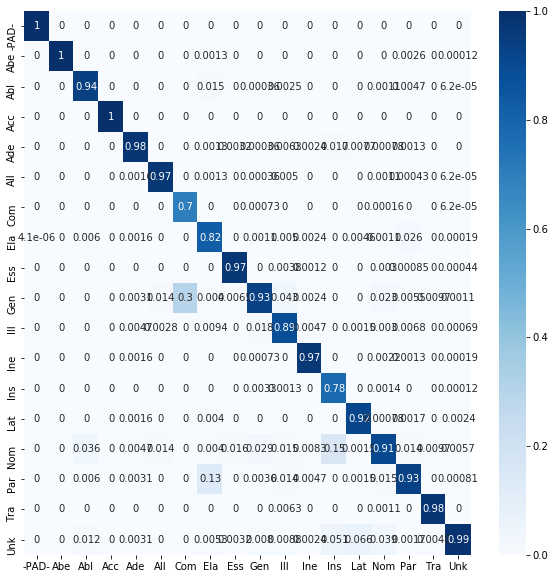

In [39]:
df_cm_1 = pd.DataFrame(array / array.sum(axis=0), index = labels, columns = labels)

plt.figure(figsize = (10,10))
sns.heatmap(df_cm_1, annot=True, cmap=plt.cm.Blues)
plt.show() 

Recall

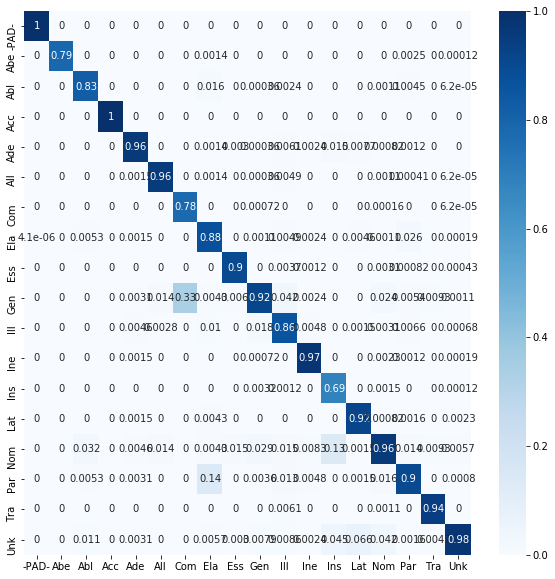

In [40]:
df_cm_2 = pd.DataFrame(array / array.sum(axis=1), index = labels, columns = labels)

plt.figure(figsize = (10,10))
sns.heatmap(df_cm_2, annot=True, cmap=plt.cm.Blues)
plt.show()